In [1]:
import pandas as pd
from pyspark.sql import Row
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from statistics import stdev

In [2]:
df_records = spark.read.csv('records.csv', header=True, inferSchema=True)
df_races = spark.read.csv('races.csv', header=True, inferSchema=True)
df_horses = spark.read.csv('horses.csv', header=True, inferSchema=True )

#df_records.printSchema()
#df_races.printSchema()
#df_horses.printSchema()

#print(df_records.count())
#print(df_races.count())
#print(df_horses.count())

### Combine Tables
 - df_records: Record_ID, Race_ID, Place,Horse_ID,Place_Section_1, Place_Section_2, Place_Section_3, Place_Section_4

- df_races: Race_ID, Date, Course, Class, Distance, Race_Type, Surface


In [3]:
## Combine the records Table with races Table
# Select the column from each table
df_records_part = df_records.select("Record_ID",
                    "Race_ID",
                    "Place",
                    "Horse_ID",
                    "Weight_Declared",
                    "Place_Section_1",
                    "Place_Section_2",
                    "Place_Section_3",
                    "Place_Section_4")\
                                .withColumnRenamed('Weight_Declared','WeightD')\
                                .withColumnRenamed('Place_Section_1','PSec1')\
                                .withColumnRenamed('Place_Section_2','PSec2')\
                                .withColumnRenamed('Place_Section_3','PSec3')\
                                .withColumnRenamed('Place_Section_4','PSec4')

df_races_part = df_races.select("Race_ID", "Date", "Course","Class","Distance", "Race_Type", "Surface")

condition = [df_records_part.Race_ID == df_races_part.Race_ID]
df_records_races = df_records_part.join(df_races_part, condition, 'leftouter' )\
                                    .select('*')
# Transform to Panda Dataframe
#print(df_records_races.count())
#df_records_races.printSchema()
panda_records_races = df_records_races.toPandas()
panda_records_races.head(5)

,Record_ID,Race_ID,Place,Horse_ID,WeightD,PSec1,PSec2,PSec3,PSec4,Race_ID,Date,Course,Class,Distance,Race_Type,Surface
0,2,1,1,1628,1186,1.0,1.0,1.0,1.0,1,2021-01-17,Sha Tin,Class 5,1600.0,SWAN HANDICAP,TURF - A Course
1,3,1,2,1023,1107,5.0,5.0,5.0,2.0,1,2021-01-17,Sha Tin,Class 5,1600.0,SWAN HANDICAP,TURF - A Course
2,4,1,3,679,1053,8.0,8.0,8.0,3.0,1,2021-01-17,Sha Tin,Class 5,1600.0,SWAN HANDICAP,TURF - A Course
3,5,1,4,2090,1087,12.0,11.0,9.0,4.0,1,2021-01-17,Sha Tin,Class 5,1600.0,SWAN HANDICAP,TURF - A Course
4,6,1,5,1386,1075,3.0,3.0,4.0,5.0,1,2021-01-17,Sha Tin,Class 5,1600.0,SWAN HANDICAP,TURF - A Course


# Display the top 3 Horse's that place 1

In [4]:
df_records_races_place1 = df_records_races.select("*").filter("Place == '1' ")
df_records_races_place1_horse = df_records_races_place1.groupBy("Horse_ID").count().withColumnRenamed('count','Count')\
                                                        .orderBy('Count', ascending=False)
df_records_races_place1_horse.show(3)

+--------+-----+
|Horse_ID|Count|
+--------+-----+
|    2222|   18|
|    1044|   17|
|    7660|   16|
+--------+-----+
only showing top 3 rows



# Display the most popular Distance

In [5]:
# Looking at Distance Category and the count
df_records_races_distinct = df_records_races.select("Distance")\
                                            .groupBy("Distance").count()\
                                            .withColumnRenamed('count','Count')\
                                            .orderBy('Count', ascending=False)
df_records_races_distinct.show(10)

+--------+-----+
|Distance|Count|
+--------+-----+
|  1200.0|73372|
|  1400.0|59882|
|  1650.0|47599|
|  1600.0|34760|
|  1800.0|30021|
|  1000.0|28381|
|  2000.0| 8657|
|  1235.0| 6588|
|  2200.0| 4599|
|  1030.0| 3592|
+--------+-----+
only showing top 10 rows



# Separate Table for Records_Races in Shatin for 3 types of Distance
- 1400, 1200 and 1000

In [6]:
# make a separate table for df_records_races with just Sha Tin Course
df_records_races_shatin = df_records_races.select("*")\
                                            .filter("Course == 'Sha Tin' ")

# make a separate table for shatin course distance 1400
df_records_races_shatin_dist1400 = df_records_races_shatin.select("*")\
                                                            .filter(df_records_races_shatin.Distance == 1400.0)
# make a separate table for shatin course distance 1200
df_records_races_shatin_dist1200 = df_records_races_shatin.select("*")\
                                                            .filter(df_records_races_shatin.Distance == 1200.0)

# make a separate table for shatin course distance 1000
df_records_races_shatin_dist1000 = df_records_races_shatin.select("*")\
                                                            .filter(df_records_races_shatin.Distance == 1000.0)



In [7]:
df_records_races_shatin_dist1000_place123 = df_records_races_shatin_dist1000.select("*")\
                                                            .filter("Place =='1' or Place =='2' or Place =='3' ")

## Analyze the Top 3 Horses raced in ShaTin

In [8]:
# horse 2222
df_records_races_shatin_2222 = df_records_races_shatin.select("*").filter("Horse_ID == '2222'")
# Panda Dataframe
panda2222 = df_records_races_shatin_2222.toPandas()

# horse 1044
df_records_races_shatin_1044 = df_records_races_shatin.select("*").filter("Horse_ID == '1044'")
# Panda Dataframe
panda1044 = df_records_races_shatin_1044.toPandas()

# horse 7660
df_records_races_shatin_7660 = df_records_races_shatin.select("*").filter("Horse_ID == '7660'")
# Panda Dataframe
panda7660 = df_records_races_shatin_7660.toPandas()


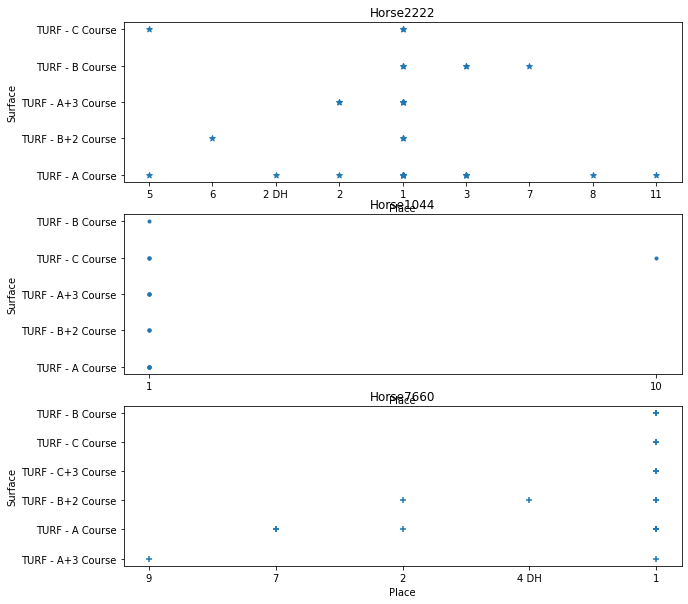

In [9]:
# Plotting Place vs Surface of the track for top 3 horses (SHATIN)
panda_place2222 = panda2222['Place']
panda_surface2222 = panda2222['Surface']
panda_place1044 = panda1044['Place']
panda_surface1044 = panda1044['Surface']
panda_place7660 = panda7660['Place']
panda_surface7660 = panda7660['Surface']


fig = plt.figure(figsize=(10, 10))
fig.add_subplot(3,1,1) 
plt.scatter(panda_place2222, panda_surface2222, marker='*')
plt.title('Horse2222')
plt.ylabel('Surface')
plt.xlabel('Place')
fig.add_subplot(3,1,2) 
plt.scatter(panda_place1044, panda_surface1044,marker='.')
plt.title('Horse1044')
plt.ylabel('Surface')
plt.xlabel('Place')
fig.add_subplot(3,1,3) 
plt.scatter(panda_place7660, panda_surface7660,marker='+')
plt.title('Horse7660')
plt.ylabel('Surface')
plt.xlabel('Place')
plt.show()

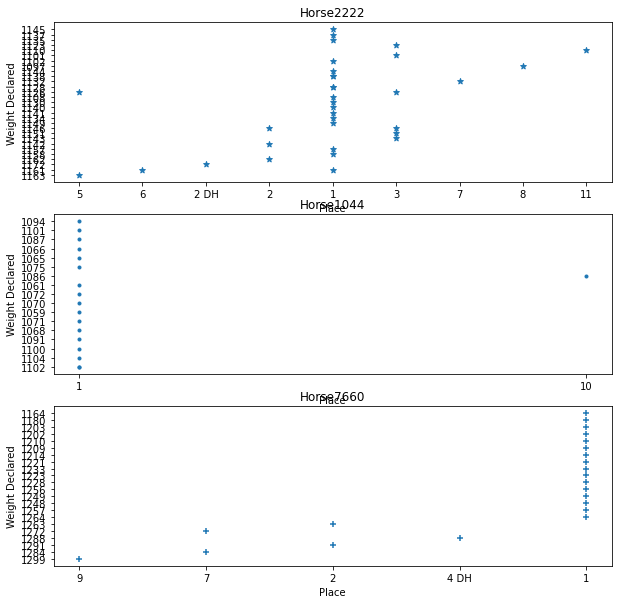

In [10]:
# Plotting Place vs weight of the horse for top 3 horses (SHATIN)
panda_place2222 = panda2222['Place']
panda_weight2222 = panda2222['WeightD']
panda_place1044 = panda1044['Place']
panda_weight1044 = panda1044['WeightD']
panda_place7660 = panda7660['Place']
panda_weight7660 = panda7660['WeightD']


fig = plt.figure(figsize=(10, 10))
fig.add_subplot(3,1,1) 
plt.scatter(panda_place2222, panda_weight2222, marker='*')
plt.title('Horse2222')
plt.ylabel('Weight Declared')
plt.xlabel('Place')
fig.add_subplot(3,1,2) 
plt.scatter(panda_place1044, panda_weight1044,marker='.')
plt.title('Horse1044')
plt.ylabel('Weight Declared')
plt.xlabel('Place')
fig.add_subplot(3,1,3) 
plt.scatter(panda_place7660, panda_weight7660,marker='+')
plt.title('Horse7660')
plt.ylabel('Weight Declared')
plt.xlabel('Place')
plt.show()

## Plot 3D Scatterplot for just Horse 2222 Place vs Surface vs Weight

In [11]:
panda2222plot = panda2222.copy()

# Find the 2 DH
index_list = []
for i in range(0, len(panda2222plot)):
    if panda2222plot.iloc[i,2] == '2 DH':
        index_list.append(i)

# remove 2 DH
panda2222plot.drop(index_list[0], inplace = True)
panda2222plot.reset_index(drop = True, inplace=True, )

# give surface category numerical representation
surface_col = list(set(panda2222plot['Surface']))
dict_condition = {}
count = 1
for element in surface_col:
    dict_condition[element] = count
    count += 1
print(surface_col)
print(dict_condition)

# Replace the Surface Value with the numerical representation
panda2222plot_02 = panda2222plot.copy()
for keys in dict_condition:
    val = dict_condition[keys]
    panda2222plot_02['Surface'] = panda2222plot_02['Surface'].replace(keys,val) 

['TURF - A+3 Course', 'TURF - C Course', 'TURF - B Course', 'TURF - A Course', 'TURF - B+2 Course']
{'TURF - A+3 Course': 1, 'TURF - C Course': 2, 'TURF - B Course': 3, 'TURF - A Course': 4, 'TURF - B+2 Course': 5}


([<matplotlib.axis.XTick at 0x7f0c11ce54f0>,
 [Text(0, 0, 'TURF - A+3 Course'),
  Text(0, 0, 'TURF - C Course'),
  Text(0, 0, 'TURF - B Course'),
  Text(0, 0, 'TURF - A Course'),
  Text(0, 0, 'TURF - B+2 Course')])

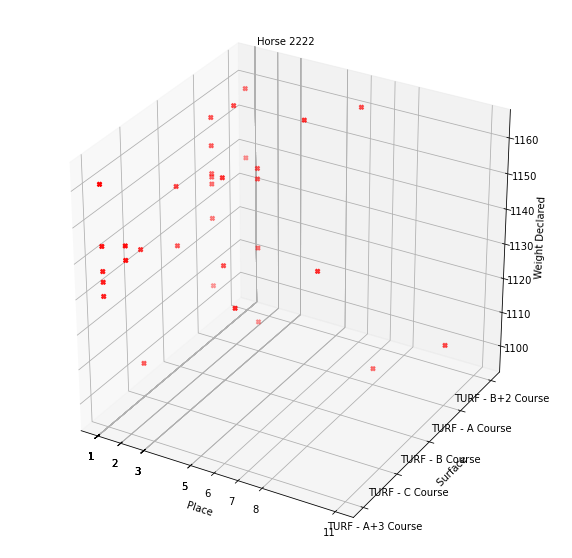

In [12]:
# Plot 3D Scatterplot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x= panda2222plot_02["Place"].astype(int)
y= panda2222plot_02["Surface"].astype(int)
z = panda2222plot_02['WeightD'].astype(int)

ax.scatter(x,y,z, c = 'r', marker = 'X')
ax.set_xlabel(" Place ", fontsize=10)
ax.set_ylabel(" Surface ", fontsize=10)
ax.set_zlabel(" Weight Declared", fontsize=10)
plt.title("Horse 2222", fontsize=10)
plt.xticks(x)
plt.yticks([1,2,3,4,5], surface_col)